<a href="https://colab.research.google.com/github/janosepah/ML_Project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Electricity Supply and Demand
Team Members (alphabetical order):
-	Samarah Azimpoor
-	Safoura Janosepah


# Power Data Source - IESO

## Market Demand
### Market Demand Definitions and Graphs
The graph below plots values for both Total Market Demand and Ontario Demand.

- **Total Market Demand** represents the total energy that was supplied from the IESO-Administered Market.

The IESO calculates Total Market Demand by summing all output from generators registered in the Market plus all scheduled imports to the province. It is also equal to the sum of all load supplied from the Market plus exports from the province, plus all line losses incurred on the IESO-controlled grid.

- **Ontario Demand** represents the total energy that was supplied from the IESO-Administered Market for the purpose of supplying load within Ontario.

It is also equal to the sum of all loads within Ontario which is supplied from the Market, plus all line losses incurred on the IESO-controlled grid.


##**Table of Content**

1.   Importing Liblaries
2.   Loading the Data
3.   Data Pre-Processing
4.   Feature Engineering
5.   Data Visualisation
6.   Designing Models
 
 6.1.   XGBoost_Demand & Supply
       * Train & Test Split
       * Creating XGBoost model
       * Prediction
       * EvaluationList item
 
 6.2.  RNN _Demand & Supply
       * Train & Test Split
       * Creating RNN model
       * Prediction
       * EvaluationList item
 
7.    Evaluating Final Models



##1. **Importing Liblaries**

In [495]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import calendar
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [496]:
# Set default plot styles
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

##2. **Loading The Data**

In [497]:
# Load Data 
Data_Path = 'https://raw.githubusercontent.com/janosepah/ML_Project/master/Data/'

# Demand
Demand_2015 = pd.read_csv(Data_Path + 'PUB_Demand_2015.csv', parse_dates=['Date'])
Demand_2015.head()

Demand_2016 = pd.read_csv(Data_Path + 'PUB_Demand_2016.csv', parse_dates=['Date'])
Demand_2016.head()

Demand_2017 = pd.read_csv(Data_Path + 'PUB_Demand_2017.csv', parse_dates=['Date'])
Demand_2017.head()
#Demand_2017.shape

Demand_2018 = pd.read_csv(Data_Path + 'PUB_Demand_2018.csv', parse_dates=['Date'])
Demand_2018.head()
#Demand_2018.shape

Demand_2019 = pd.read_csv(Data_Path + 'PUB_Demand_2019.csv', parse_dates=['Date'])
Demand_2019.head()
#Demand_2019.shape

# Supply
Supply_2015 = pd.read_csv(Data_Path + '2015_Hourly_Output.csv', parse_dates=['Date'])
Supply_2015.head()

Supply_2016 = pd.read_csv(Data_Path + '2016_Hourly_Output.csv', parse_dates=['Date'])
Supply_2016.head()

Supply_2017 = pd.read_csv(Data_Path + '2017_Hourly_Output.csv', parse_dates=['Date'])
Supply_2017.head()
#Supply_2017.shape

Supply_2018 = pd.read_csv(Data_Path + '2018_Hourly_Output.csv', parse_dates=['Date'])
Supply_2018.head()
#Supply_2018.shape

Supply_2019 = pd.read_csv(Data_Path + '2019_Hourly_Output.csv', parse_dates=['Date'])
Supply_2019.head()
#Supply_2019.shape


# FuelMonthly

FuelMonthly_2015 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2015.csv')
FuelMonthly_2015.head()

FuelMonthly_2016 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2016.csv')
FuelMonthly_2016.head()

FuelMonthly_2017 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2017.csv')
FuelMonthly_2017.head()

FuelMonthly_2018 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2018.csv')
FuelMonthly_2018.head()

FuelMonthly_2019 =pd.read_csv(Data_Path + 'GenOutputbyFuelMonthly_2019.csv')
FuelMonthly_2019.head()


,Month,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output
0,January,8057.99,941.07,3422.35,1435.37,24.86,30.93,13912.6
1,February,6320.06,1261.45,3182.15,1205.47,30.39,22.72,12022.2
2,March,6547.15,1262.38,3183.01,1269.84,59.24,33.84,12355.5
3,April,6580.45,432.65,3138.32,1065.94,64.42,29.50,11311.3
4,May,6981.78,370.93,3653.81,633.64,72.41,31.32,11743.9


## 3. Data Pre-Processing

Merging Data

In [498]:
# Demand
AllDemand= Demand_2015.append(Demand_2016)
AllDemand= AllDemand.append(Demand_2017)
AllDemand= AllDemand.append(Demand_2018)
AllDemand= AllDemand.append(Demand_2019)

#AllDemand.shape

# Supply
AllSupply= Supply_2015.append(Supply_2016)
AllSupply= AllSupply.append(Supply_2017)
AllSupply= AllSupply.append(Supply_2018)
AllSupply= AllSupply.append(Supply_2019)
#AllSupply.shape

# FuelMonthly
AllFuel= FuelMonthly_2015.append(FuelMonthly_2016)
AllFuel= AllFuel.append(FuelMonthly_2017)
AllFuel= AllFuel.append(FuelMonthly_2018)
AllFuel= AllFuel.append(FuelMonthly_2019)

# Supply Details
Supply_Details = pd.merge(AllSupply, AllDemand, how="left", on=["Date", "Hour"])


In [499]:
Supply_Details.head()
#Supply_Details.shape

,Date,Hour,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output,Market Demand,Ontario Demand
0,2015-01-01,1.0,11564.0,957.0,3173.0,2504.0,0.0,20.0,18218.0,18358.0,14960.0
1,2015-01-01,2.0,11560.0,946.0,3100.0,2262.0,0.0,20.0,17888.0,18012.0,14476.0
2,2015-01-01,3.0,11560.0,947.0,3051.0,2025.0,0.0,20.0,17603.0,17795.0,13979.0
3,2015-01-01,4.0,11444.0,949.0,3086.0,1950.0,0.0,22.0,17451.0,17559.0,13670.0
4,2015-01-01,5.0,11174.0,946.0,3131.0,2015.0,0.0,21.0,17287.0,17402.0,13567.0


In [500]:
AllFuel.head()

,Month,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output
0,January,8489.15,1846.24,3567.44,950.34,1.15,34.06,14888.4
1,February,7731.11,2385.53,3020.66,768.91,1.49,29.38,13937.1
2,March,8749.34,1066.95,3063.28,811.73,15.17,41.95,13748.4
3,April,7451.97,752.23,2945.79,852.20,22.33,27.66,12052.2
4,May,7433.69,757.49,3336.00,628.54,26.53,38.07,12220.3


In [501]:
AllSupply.head()

,Date,Hour,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output
0,2015-01-01,1.0,11564.0,957.0,3173.0,2504.0,0.0,20.0,18218.0
1,2015-01-01,2.0,11560.0,946.0,3100.0,2262.0,0.0,20.0,17888.0
2,2015-01-01,3.0,11560.0,947.0,3051.0,2025.0,0.0,20.0,17603.0
3,2015-01-01,4.0,11444.0,949.0,3086.0,1950.0,0.0,22.0,17451.0
4,2015-01-01,5.0,11174.0,946.0,3131.0,2015.0,0.0,21.0,17287.0


In [502]:
AllDemand.head()

,Date,Hour,Market Demand,Ontario Demand
0,2015-01-01,1,18358,14960
1,2015-01-01,2,18012,14476
2,2015-01-01,3,17795,13979
3,2015-01-01,4,17559,13670
4,2015-01-01,5,17402,13567


##4. Feature Engineering



Adding some featurs to the dataset

In [503]:
# Add Day & Month
# Demand
AllDemand['Date'] = pd.to_datetime(AllDemand['Date']) 
AllDemand['Day'] = AllDemand['Date'].dt.day_name() 
AllDemand['Month'] = pd.DatetimeIndex(AllDemand['Date']).month 
#AllDemand['Month'] = AllDemand['Month'].apply(lambda x: calendar.month_abbr[x])

# Supply
AllSupply['Date'] = pd.to_datetime(AllSupply['Date']) 
AllSupply['Day'] = AllSupply['Date'].dt.day_name()
AllSupply['Month'] = pd.DatetimeIndex(AllSupply['Date']).month 
#AllSupply['Month'] = AllSupply['Month'].apply(lambda x: calendar.month_abbr[x])


In [504]:
#Add Index
AllDemand.set_index(['Date'], inplace=True)
AllSupply.set_index(['Date'], inplace=True)
Supply_Details.set_index(['Date'], inplace=True)

In [505]:
# Keeping the main Columns

Demand = AllDemand 

##5. Data Visualisation

**Exploratory Analysis**
Since the frequency currently is in the hourly level, this will make it difficult to visualise. So we will resample it and aggregate it to a daily/weekly and monthly level.

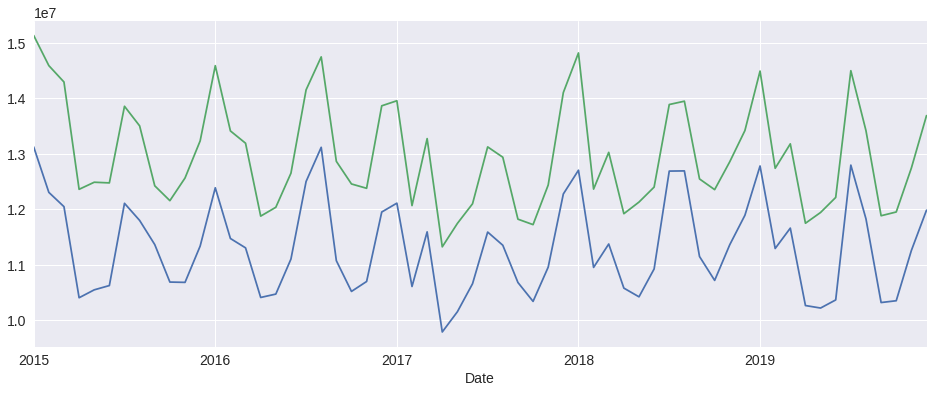

In [350]:
MonthlyDemand = AllDemand.resample(rule='M').sum()
MonthlyDemand = MonthlyDemand.asfreq('M')
MonthlyDemand['Ontario Demand'].plot();
MonthlyDemand['Market Demand'].plot();

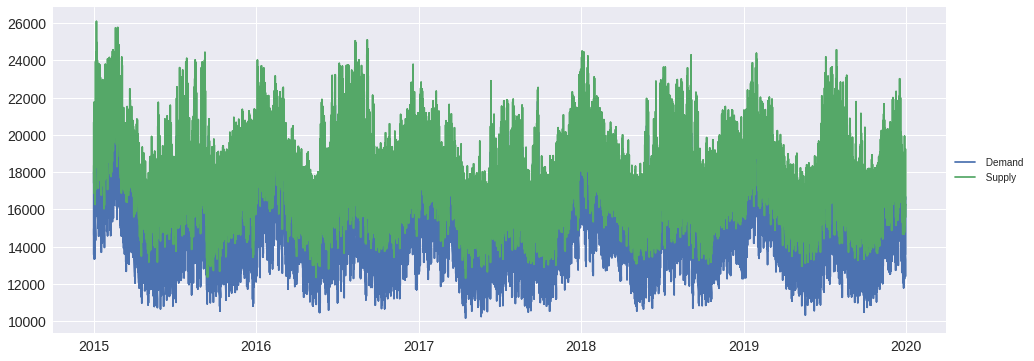

In [351]:
y2=AllDemand['Ontario Demand']
y3= AllDemand['Market Demand']
x= MonthlyDemand
plt.plot(y2,label=' Demand')
plt.plot(y3,label=' Supply')

# use parameter bbox_to_anchor to reposition
# the legend box outside the plot area
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

As it is clear in the plot, the Electricity consumption has the highest usage in Jan/Dec.This might be due to several factors, the most obvious being new year and more electricity demand. Another major factor is the correlation between general weather condition and electricity usage. Extreme High and cold temperatures encourage more electricity usage as office buildings and homes require cooling and heating.


**Data Visualisation**
We can see the pattern in data- electricity usage seem to be very seasonal and repetitive. This makes sense, it migh be due to weather patterns,  holidays, weekends etc.
Furthermore, you can see the trend of the data seems to be trailing upwards in the last few years.

In [352]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter

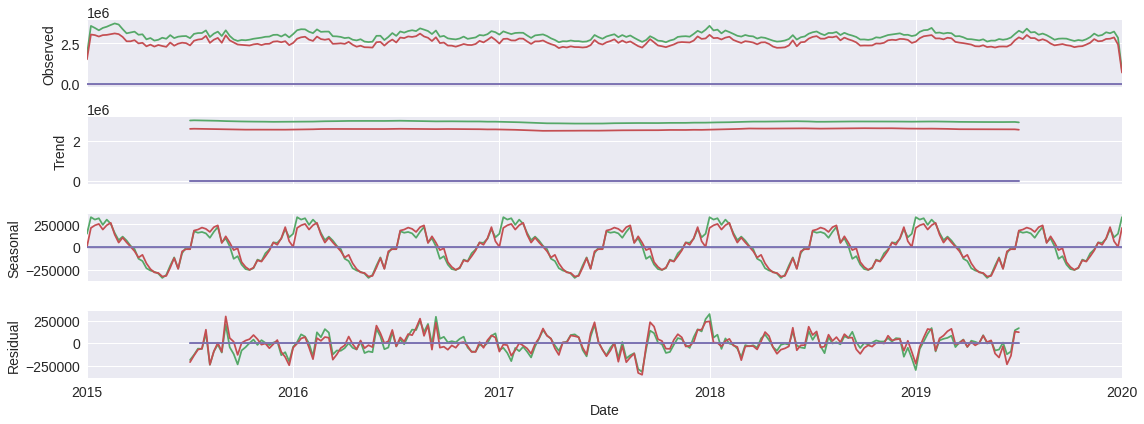

In [353]:
weekly_data = Demand.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
plt.show()

## 6. Designing Models

###6.1. XGBoost _ Demand



Normalisation is not needed for XGBOOST.

Reason:
Decision Trees do not require normalization of their inputs; and since XGBoost is essentially en ensemble algorithm comprised of Decision Trees, it does not require normalization for the inputs either.

####Train & Test Split


In [354]:
split_date = '31-Dec-2018'
Demand_Train = Demand.loc[Demand.index <= split_date].copy() #changed from df_norm
Demand_Test = Demand.loc[Demand.index > split_date].copy() #changed from df_norm

In [355]:
print(Demand.shape)
print(Demand_Train.shape)
print(Demand_Test.shape)

(43824, 5)
(35064, 5)
(8760, 5)


Text(0.0, 1.0, 'Train - Test Split')

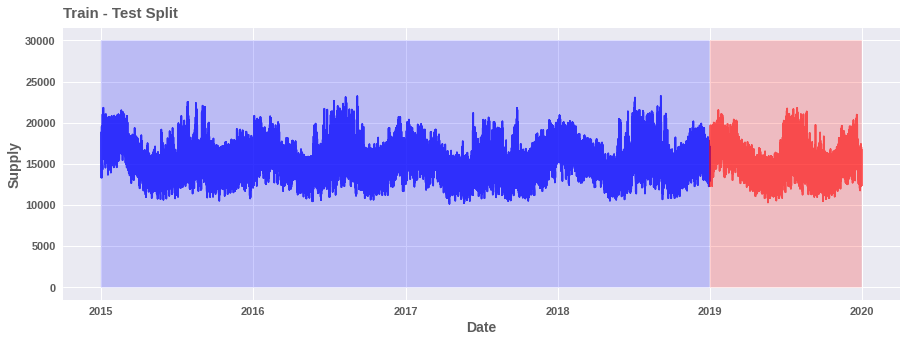

In [356]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 30000

plt.plot(Demand_Train.index,Demand_Train["Ontario Demand"],color="blue", alpha=0.75)
plt.fill_between(Demand_Train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(Demand_Test.index,Demand_Test["Ontario Demand"], color = "red", alpha=0.60)
plt.fill_between(Demand_Test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Demand", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

Now we will create some Time Series Features

date, hour, dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear

In [357]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Date'] = df.index
    df['Hour'] = df['Hour']
    df['Dayofweek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month_Num'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Dayofyear'] = df['Date'].dt.dayofyear
    df['Dayofmonth'] = df['Date'].dt.day
    df['Weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['Hour','Dayofweek','Quarter','Month_Num','Year',
           'Dayofyear','Dayofmonth','Weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [358]:
X_train, y_train = create_features(Demand_Train, label='Ontario Demand') 
X_test, y_test = create_features(Demand_Test, label='Ontario Demand')

In [359]:
#Just checking the output
X_train.head(5)

,Hour,Dayofweek,Quarter,Month_Num,Year,Dayofyear,Dayofmonth,Weekofyear
Date,,,,,,,,
2015-01-01,1,3,1,1,2015,1,1,1
2015-01-01,2,3,1,1,2015,1,1,1
2015-01-01,3,3,1,1,2015,1,1,1
2015-01-01,4,3,1,1,2015,1,1,1
2015-01-01,5,3,1,1,2015,1,1,1


In [360]:
y_train.head(5)

Date
2015-01-01    14960
2015-01-01    14476
2015-01-01    13979
2015-01-01    13670
2015-01-01    13567
Name: Ontario Demand, dtype: int64

####Creating XGBoost model

In [361]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

output = reg.predict(X_test)

[01:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [362]:
print(output)

[15079.51   14736.3545 14588.357  ... 15823.777  14421.551  13732.732 ]


**Feature importance**

As seen from the results, level of importance:

1.   Date
2.   Quarter
3.   Year
4.   Hour
5.   Dayofmonth
6.   Month_Num
7.   Dayofyear
8.   Dayofweek
9.   Weekofyear

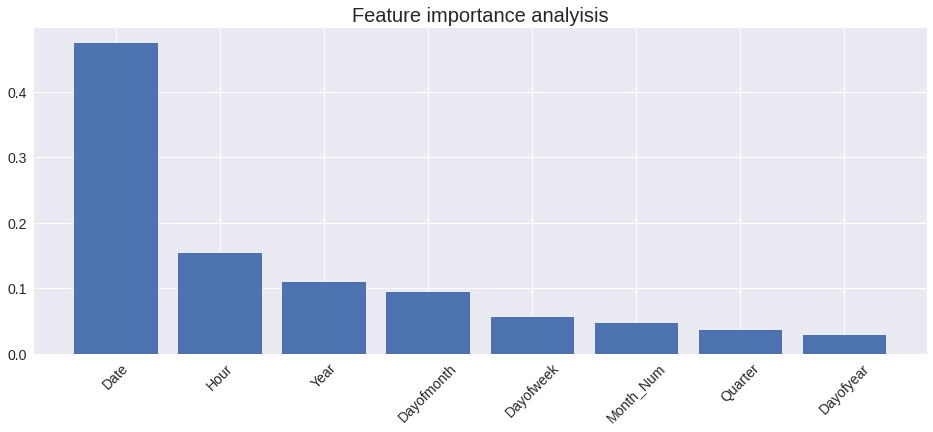

In [363]:
features = ["Date", "Hour", "Dayofweek", "Quarter", "Month_Num", "Year", "Dayofyear", "Dayofmonth", "Weekofyear"]

# Get feature importances from our random forest model
importances = reg.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

####Prediction

In [364]:
Demand_Test['Prediction'] =reg.predict(X_test)
#combining the 
Consumption_all = pd.concat([Demand_Test, Demand_Train], sort=False)

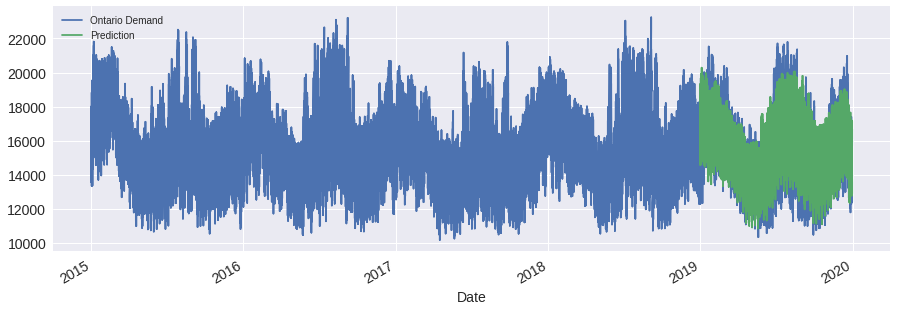

In [365]:
_ = Consumption_all[['Ontario Demand','Prediction']].plot(figsize=(15, 5))

####EvaluationList item

Error Matrix Different types of error matrix that is used:

*   R^2 (correlation score)
*   Mean Squared error
*   Mean Absolute Error

In [366]:
lstm_score = r2_score(y_test, output)
print("R^2 Score of XGBoost model = ",lstm_score)

R^2 Score of XGBoost model =  0.749010692034414


In [367]:
mean_squared_error = mean_squared_error(y_true=Demand_Test['Ontario Demand'],
                   y_pred=Demand_Test['Prediction'])
print("Mean_squared_error =", mean_squared_error)

Mean_squared_error = 1288485.7514965427


In [368]:
mean_absolute_error = mean_absolute_error(y_true=Demand_Test['Ontario Demand'],
                   y_pred=Demand_Test['Prediction'])
print("Mean_absolute_error =", mean_absolute_error)

Mean_absolute_error = 897.9707478283747


In [369]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error = mean_absolute_percentage_error(y_true=Demand_Test['Ontario Demand'],
                   y_pred=Demand_Test['Prediction'])

print("Mean_absolute_error = " + str(mean_absolute_percentage_error) + " %")

Mean_absolute_error = 5.897656674566381 %


For XGBoost, the results are:

*   R^2 Score of XGBoost model =  0.749010692034414
*   Mean_squared_error = 1288485.7514965427
*   Mean_absolute_error = 897.9707478283747
*   Mean_absolute_error = 5.897656674566381 %

###6.1. XGBoost _Supply



Normalisation is not needed for XGBOOST.

Reason:
Decision Trees do not require normalization of their inputs; and since XGBoost is essentially en ensemble algorithm comprised of Decision Trees, it does not require normalization for the inputs either.

####Train & Test Split


In [506]:
Supply = Supply_Details


In [507]:
split_date = '31-Dec-2018'
Supply_Train = Supply.loc[Supply.index <= split_date].copy() #changed from df_norm
Supply_Test = Supply.loc[Supply.index > split_date].copy() #changed from df_norm

In [508]:
print(Supply.shape)
print(Supply_Train.shape)
print(Supply_Test.shape)

(43825, 10)
(35064, 10)
(8760, 10)


Text(0.0, 1.0, 'Train - Test Split')

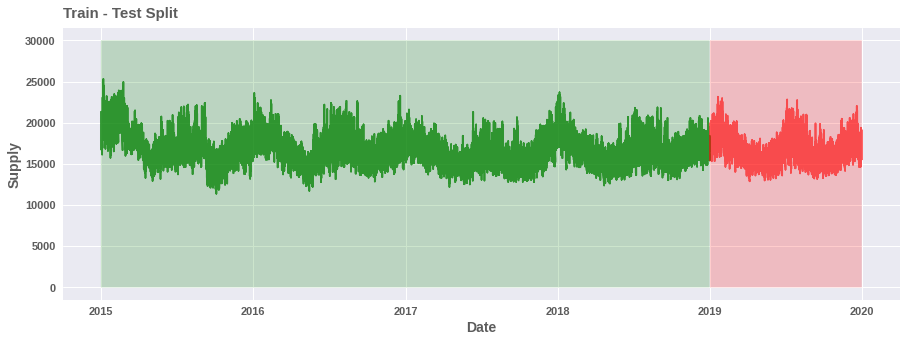

In [509]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 30000

plt.plot(Supply_Train.index,Supply_Train["Total Output"],color="green", alpha=0.75)
plt.fill_between(Supply_Train.index,coloring, facecolor="green", alpha=0.2)

plt.plot(Supply_Test.index,Supply_Test["Total Output"], color = "red", alpha=0.60)
plt.fill_between(Supply_Test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Supply", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

Now we will create some Time Series Features

date, hour, dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear

In [510]:
def create_features_fuel(df, label=None):
    X = df[['NUCLEAR',	'GAS',	'HYDRO',	'WIND',	'SOLAR',	'BIOFUEL', 'Hour']]
    if label:
        y = df[label]
        return X, y
    return X

In [511]:
X_train, y_train = create_features_fuel(Supply_Train, label='Total Output') 
X_test, y_test = create_features_fuel(Supply_Test, label='Total Output')

In [512]:
#Just checking the output
X_train.head(5)

,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Hour
Date,,,,,,,
2015-01-01,11564.0,957.0,3173.0,2504.0,0.0,20.0,1.0
2015-01-01,11560.0,946.0,3100.0,2262.0,0.0,20.0,2.0
2015-01-01,11560.0,947.0,3051.0,2025.0,0.0,20.0,3.0
2015-01-01,11444.0,949.0,3086.0,1950.0,0.0,22.0,4.0
2015-01-01,11174.0,946.0,3131.0,2015.0,0.0,21.0,5.0


In [513]:
y_train.head(5)

Date
2015-01-01    18218.0
2015-01-01    17888.0
2015-01-01    17603.0
2015-01-01    17451.0
2015-01-01    17287.0
Name: Total Output, dtype: float64

####Creating XGBoost model

In [514]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

output = reg.predict(X_test)

[04:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [515]:
print(output)

[16131.109 15839.733 15657.827 ... 16844.22  16473.736 16483.4  ]


**Feature importance**

As seen from the results, level of importance:

1.   Date
2.   Hour
3.   NUCLEAR					
4.   GAS
5.   HYDRO
6.   WIND
7.   SOLAR
8.   BIOFUEL

####Prediction

In [516]:
Supply_Test['Prediction'] =reg.predict(X_test)
#combining the 
Consumption_all = pd.concat([Supply_Test, Supply_Train], sort=False)

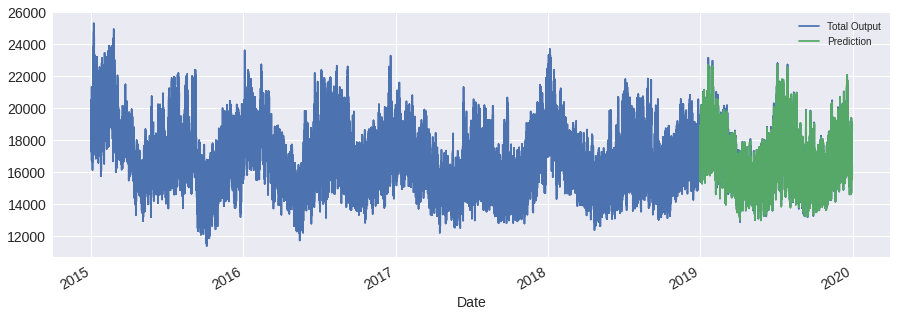

In [517]:
_ = Consumption_all[['Total Output','Prediction']].plot(figsize=(15, 5))

####EvaluationList item

Error Matrix Different types of error matrix that is used:

*   R^2 (correlation score)
*   Mean Squared error
*   Mean Absolute Error

In [518]:
Supply_Test

,Hour,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output,Market Demand,Ontario Demand,Prediction
Date,,,,,,,,,,,
2019-01-01,1.0,11215.0,232.0,3320.0,1302.0,0.0,10.0,16079.0,16231.0,13198.0,16131.109375
2019-01-01,2.0,11221.0,233.0,3274.0,1146.0,0.0,10.0,15884.0,16051.0,12737.0,15839.733398
2019-01-01,3.0,11205.0,233.0,3222.0,992.0,0.0,10.0,15662.0,15805.0,12531.0,15657.827148
2019-01-01,4.0,11205.0,234.0,3205.0,876.0,0.0,10.0,15530.0,15580.0,12291.0,15475.432617
2019-01-01,5.0,11214.0,233.0,3218.0,883.0,0.0,10.0,15558.0,15609.0,12305.0,15498.259766
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,20.0,11462.0,232.0,3819.0,2735.0,0.0,34.0,18282.0,18402.0,15909.0,18374.890625
2019-12-31,21.0,11514.0,230.0,3719.0,2066.0,0.0,34.0,17563.0,17574.0,15198.0,17646.857422
2019-12-31,22.0,11605.0,229.0,3700.0,1260.0,0.0,34.0,16828.0,16872.0,14678.0,16844.220703


In [523]:
lstm_score_S = r2_score(y_test, output)
print("R^2 Score of XGBoost model = ",lstm_score_S)

R^2 Score of XGBoost model =  0.9969160926867011


In [520]:
mean_squared_error_S = mean_squared_error(y_true=Supply_Test['Total Output'],y_pred = Supply_Test['Prediction'])
print("Mean_squared_error =", mean_squared_error_S)

Mean_squared_error = 9931.590591187456


In [521]:
mean_absolute_error_S = mean_absolute_error(y_true=Supply_Test['Total Output'],
                   y_pred = Supply_Test['Prediction'])
print("Mean_absolute_error =", mean_absolute_error_S)

Mean_absolute_error = 74.90600385273973


In [524]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error_S = mean_absolute_percentage_error(y_true=Supply_Test['Total Output'],
                   y_pred=Supply_Test['Prediction'])

print("Mean_absolute_error = " + str(mean_absolute_percentage_error_S) + " %")

Mean_absolute_error = 0.44067209672640417 %


For XGBoost, the results are:

*   R^2 Score of XGBoost model =   0.9969160926867011
*   Mean_squared_error = 9931.590591187456
*   Mean_absolute_error = 74.90600385273973
*   Mean_absolute_error = 0.44067209672640417 %

###6.2. RNN_Demand

Before normalisation of data: As you can see from the graph below, the graph has yet to be normalised.

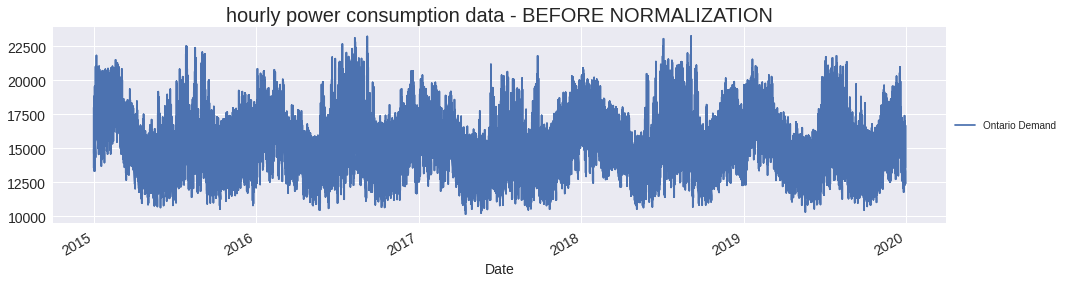

In [370]:
Demand['Ontario Demand'].plot(figsize=(16,4),legend=True)

plt.title('hourly power consumption data - BEFORE NORMALIZATION')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To normalise the data, we will be using sklearn MinMaxScalar

Normalisation is required for neural networks(i think? double check)

In [371]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['Ontario Demand']=scaler.fit_transform(df['Ontario Demand'].values.reshape(-1,1))
    return df

Demand_norm = normalize_data(AllDemand)
Demand_norm.shape

(43824, 5)

After normalization the range of power consumption values changes which we can observe on the y-axis of the graph. In the earlier graph that was displayed it was in the range 0 - 54000
Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

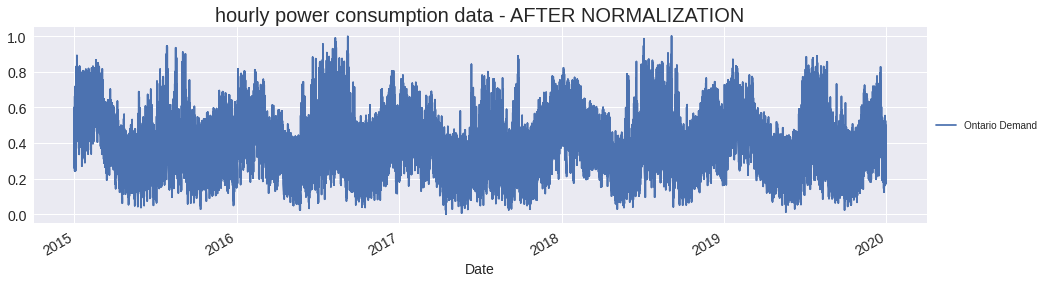

In [372]:
Demand_norm['Ontario Demand'].plot(figsize=(16,4),legend=True)

plt.title('hourly power consumption data - AFTER NORMALIZATION')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

####Train & Test Split

In [373]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)-5):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i+5, 0])

   #1 last 6189 days are going to be used in test
    X_test = X_train[35064:]             
    y_test = y_train[35064:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:35064]           
    y_train = y_train[:35064]
    
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (35064, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

####Creating RNN model

In [374]:
#create train, test data
seq_len = 70 #choose sequence length

X_train, y_train, X_test, y_test = load_data(Demand_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (35064, 70, 1)
y_train.shape =  (35064,)
X_test.shape =  (8685, 70, 1)
y_test.shape =  (8685,)


In [375]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [376]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 70, 40)            1680      
_________________________________________________________________
dropout_15 (Dropout)         (None, 70, 40)            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 70, 40)            3240      
_________________________________________________________________
dropout_16 (Dropout)         (None, 70, 40)            0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

 The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

In [377]:
rnn_model.compile(optimizer="adam",loss="MSE")
history= rnn_model.fit(X_train, y_train, epochs=17, validation_data=(X_test, y_test), batch_size=1000)

Epoch 1/17
36/36 [==============================] - 11s 310ms/step - loss: 116.1309 - val_loss: 76.1845
Epoch 2/17
36/36 [==============================] - 11s 304ms/step - loss: 68.0495 - val_loss: 60.4642
Epoch 3/17
36/36 [==============================] - 11s 306ms/step - loss: 57.4937 - val_loss: 53.6177
Epoch 4/17
36/36 [==============================] - 11s 301ms/step - loss: 52.5139 - val_loss: 50.3769
Epoch 5/17
36/36 [==============================] - 11s 300ms/step - loss: 50.2960 - val_loss: 48.8580
Epoch 6/17
36/36 [==============================] - 11s 304ms/step - loss: 49.1247 - val_loss: 48.0804
Epoch 7/17
36/36 [==============================] - 11s 310ms/step - loss: 48.1510 - val_loss: 45.9638
Epoch 8/17
36/36 [==============================] - 11s 300ms/step - loss: 44.7546 - val_loss: 37.4259
Epoch 9/17
36/36 [==============================] - 11s 302ms/step - loss: 28.9250 - val_loss: 20.3335
Epoch 10/17
36/36 [==============================] - 11s 300ms/step - lo

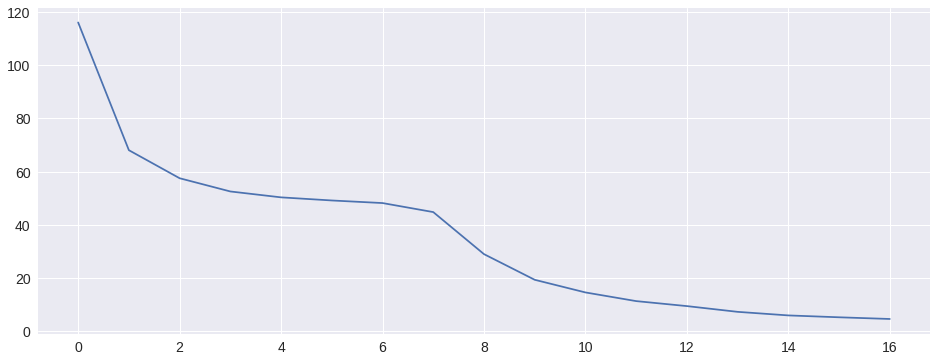

In [380]:
my_loss= rnn_model.history.history['loss']
plt.plot(range(len(my_loss)),my_loss)

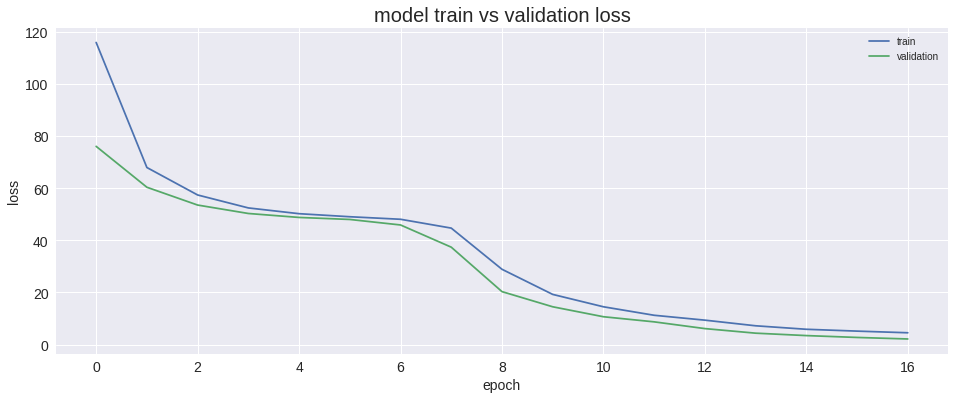

In [381]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Based on the graph, both validation loss and loss have been decreasing as # of epochs increases



####Prediction

In [386]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R^2 Score of RNN model = ",rnn_score)

R^2 Score of RNN model =  0.9555675746500223


It seems like the RNN model is doing a significantly better job than the XGBoost model (R2 Score = 0.749010692034414) (Maybe need to double check cause the difference is quite large)

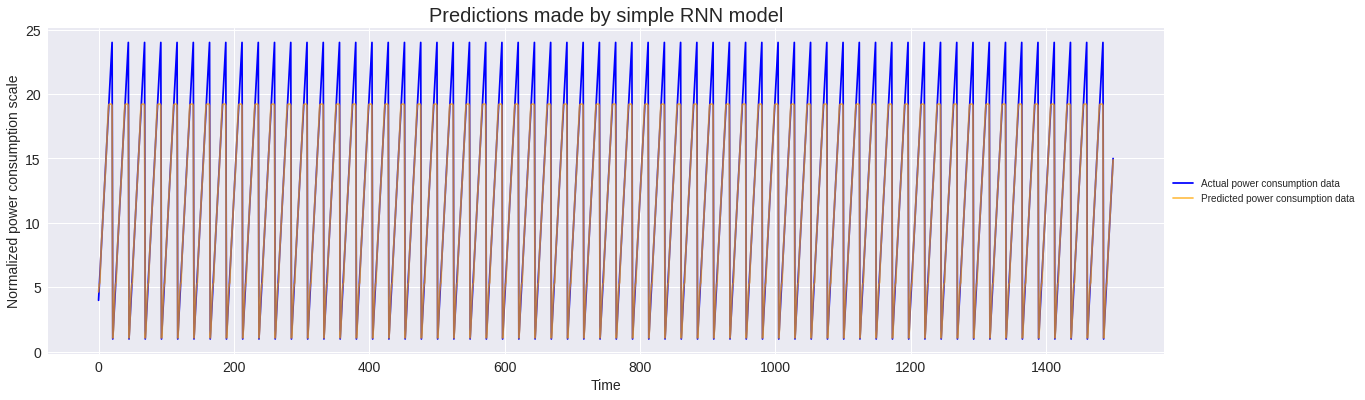

In [405]:
plt.figure(figsize=(20,6))
plt.plot(y_test[:1500], color='blue',label='Actual power consumption data')
plt.plot(rnn_predictions[:1500], alpha=0.7, color='orange',label='Predicted power consumption data')
plt.title("Predictions made by simple RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
  

Before normalisation of data: As you can see from the graph below, the graph has yet to be normalised.

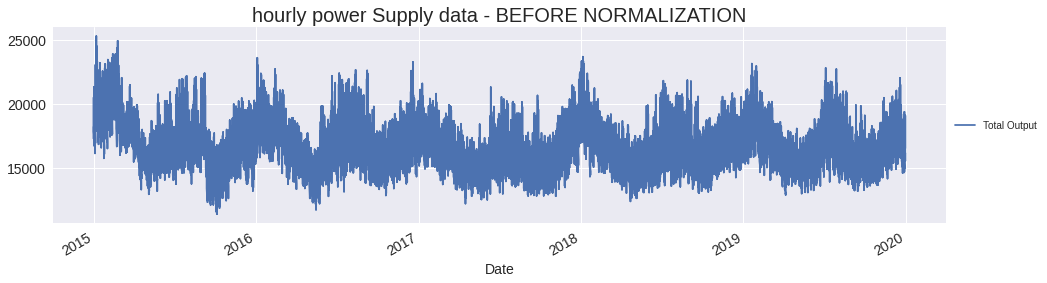

In [525]:
Supply['Total Output'].plot(figsize=(16,4),legend=True)

plt.title('hourly power Supply data - BEFORE NORMALIZATION')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To normalise the data, we will be using sklearn MinMaxScalar

Normalisation is required for neural networks(i think? double check)

In [526]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['Total Output']=scaler.fit_transform(df['Total Output'].values.reshape(-1,1))
    return df

Supply_norm = normalize_data(Supply)
Supply_norm.shape

(43825, 10)

After normalization the range of power consumption values changes which we can observe on the y-axis of the graph. In the earlier graph that was displayed it was in the range 0 - 54000
Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

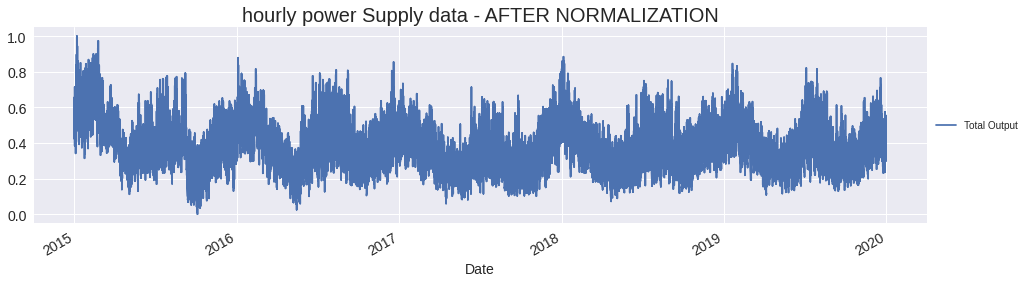

In [527]:
Supply_norm['Total Output'].plot(figsize=(16,4),legend=True)

plt.title('hourly power Supply data - AFTER NORMALIZATION')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

####Train & Test Split

In [556]:
split_date = '31-Dec-2018'
Supply_train = Supply.loc[Supply.index <= split_date].copy() #changed from df_norm
Supply_test = Supply.loc[Supply.index > split_date].copy() #changed from df_norm

In [557]:
print(Supply.shape)
print(Supply_train.shape)
print(Supply_test.shape)

(43825, 10)
(35064, 10)
(8760, 10)


In [572]:
#Train - Test
X_train = Supply_train.drop("Total Output", axis=1) 
y_train = Supply_train["Total Output"]
X_test = Supply_test.drop("Total Output", axis=1)
y_test = Supply_test["Total Output"]

####Creating  model

In [576]:
def randomForestRegresssion(df_X, df_Y):
    
    from sklearn.cross_validation import train_test_split
    from sklearn import grid_search
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import metrics
    from scipy import stats

    # Split into training/testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)

    # Gridsearch
    params = {
            'max_features': ['log2'],
            'n_estimators': [75],
            'max_depth': [None],
            'min_samples_split': [2]
    }
    clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), params, cv=5, n_jobs=1)
    fit = clf.fit(X_train, y_train)


    # Best Estimator
    rf = fit.best_estimator_


    # Metrics
    print ('Best Params: ', fit.best_params_)
    print ('Best Score: ', fit.best_score_)
    preds = rf.predict(X_test)
    print ('R2 Score: ', metrics.r2_score(y_test.values, preds))
    print ('Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds))
    print ('MAE: ', metrics.mean_absolute_error(y_test.values, preds))
    print ('MSE: ', metrics.mean_squared_error(y_test.values, preds))
    print ('Median AE: ', metrics.median_absolute_error(y_test.values, preds))

    # Feature Importances
    lcols = X_train.columns
    display( pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort_values('Feature Importances', ascending=False) )
    
    return rf

####Prediction

In [569]:
Supply_test["Prediction"] = xgd_reg.predict(X_test)

NameError: ignored

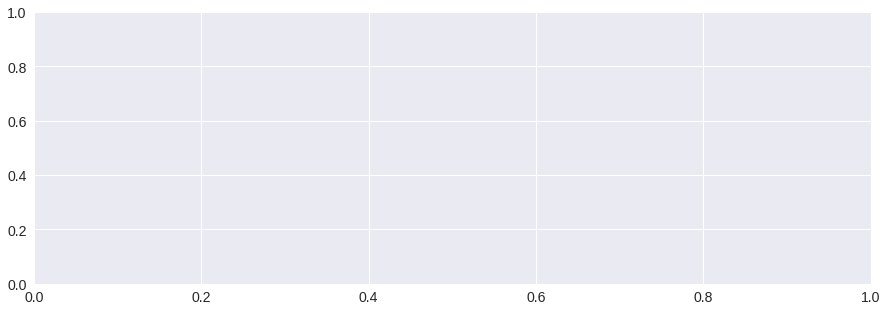

In [570]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(consum_train.index,consum_train["PJME_MW"],alpha=.3)
plt.plot(consum_test.index,consum_test["Prediction"])
plt.plot(consum_test.index,consum_test["PJME_MW"],alpha=.3)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
  